/tmp/ipython-input-2057193562.py:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
/tmp/ipython-input-2057193562.py:74: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.1))


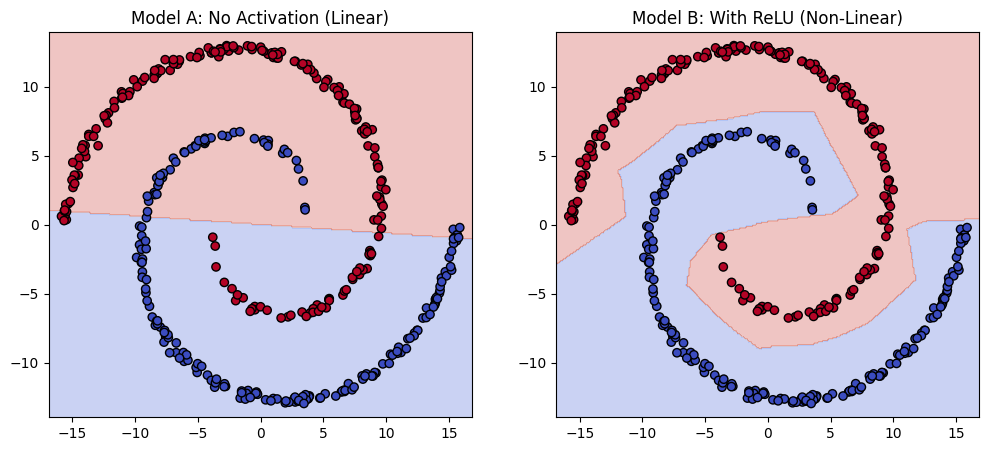

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# --- 1. スパイラルデータの生成 ---
def generate_spiral_data(n_samples=100):
    # クラス数 (2クラス: 赤と青)
    theta = np.sqrt(np.random.rand(n_samples)) * 2 * np.pi

    # クラス0 (赤) の渦
    r_a = 2 * theta + np.pi
    data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
    x_a = data_a + np.random.randn(n_samples, 2) * 0.2

    # クラス1 (青) の渦
    r_b = -2 * theta - np.pi
    data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
    x_b = data_b + np.random.randn(n_samples, 2) * 0.2

    # データを結合
    X = np.vstack([x_a, x_b])
    y = np.hstack([np.zeros(n_samples), np.ones(n_samples)])
    return torch.FloatTensor(X), torch.LongTensor(y)

# データを生成
X, y = generate_spiral_data(200)

# --- 2. モデルの定義 ---
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 活性化関数なし（線形）
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 2)
    def forward(self, x):
        x = self.layer1(x)
        # ここに活性化関数がない！
        x = self.layer2(x)
        return x

class NonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # ReLUあり（非線形）
        self.layer1 = nn.Linear(2, 20)
        self.activation = nn.ReLU() # <--- これが魔法の素
        self.layer2 = nn.Linear(20, 2)
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x) # 非線形変換！
        x = self.layer2(x)
        return x

# --- 3. 学習と可視化の関数 ---
def train_and_visualize(model, title):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # 1000回学習
    for i in range(1000):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    # --- 決定境界の可視化 ---
    # グリッドを作る
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # グリッドの全点について予測
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        pred = model(grid_tensor).argmax(dim=1)
    pred = pred.reshape(xx.shape)

    # プロット
    plt.contourf(xx, yy, pred, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)

# --- 4. 実行と結果表示 ---
plt.figure(figsize=(12, 5))

# 実験A: 線形モデル（活性化関数なし）
plt.subplot(1, 2, 1)
linear_model = LinearModel()
train_and_visualize(linear_model, "Model A: No Activation (Linear)")

# 実験B: 非線形モデル（ReLUあり）
plt.subplot(1, 2, 2)
nonlinear_model = NonLinearModel()
train_and_visualize(nonlinear_model, "Model B: With ReLU (Non-Linear)")

plt.show()